# Transfer entropy for Heartbeat process

_Copyright (C) 2023-, Joseph T. Lizier
Distributed under GNU General Public License v3_

In this activity we will compute the local Transfer entropy on the Heartbeat (Poisson switching) process.

1. Start by generating some sample data for this process:
    1. The function `generateHeartbeatMessages` which will generate the data is defined in the code cell below.
    2. Add a line in the next cell after that: `data = generateHeartbeatMessages(0.05, 0.2, 100000);` to generate `N=100000` time steps of sample data for a heartbeat process with transition probabilities (as defined in lecture) `lambda1 = 0.05; lambda0 = 0.2`. And run both code cells.

In [1]:
import numpy

"""function generateHeartbeatMessages(lambda1, lambda0, N)

Generate sample time series data, of N time steps, for two processes.
The first process s is a Poisson switching process, where the next value s_{n+1}
 is a simple function of its previous value s_n:

 p(s_{n+1} = 1 | s_n = 0) = lambda1
 p(s_{n+1} = 0 | s_n = 0) = 1-lambda1
 p(s_{n+1} = 1 | s_n = 1) = 1-lambda0
 p(s_{n+1} = 0 | s_n = 1) = lambda0

The second process t simply copies the previous value of s.

We have for the steady-state probabilities:
 p(s_n = 0) = lambda0 / (lambda0 + lambda1)
 p(s_n = 1) = lambda1 / (lambda0 + lambda1)
Proof:
 p(1) = p(0).p(s_{n+1} = 1 | s_n = 0) + p(1).p(s_{n+1} = 1 | s_n = 1)
      = p(0).lambda1 + p(1).(1-lambda0)
 p(1) = lambda1/lambda0 . p(0)
and: p(1) + p(0) = 1
Solve these two equations to get the above result.

Inputs:
- lambda1 - probability of switching to 1 when current value is a 0
- lambda0 - probability of switching to 0 when current value is a 1
- N - number of time steps to generate

Output:
- data - Nx2 matrix. First column is process s, second column is process t.

Copyright (C) 2017, Joseph T. Lizier
Distributed under GNU General Public License v3
"""
def generateHeartbeatMessages(lambda1, lambda0, N):

    s = numpy.zeros((N));
    t = numpy.zeros((N));
    # One can show:
    p1 = lambda1 / (lambda0 + lambda1);
    p0 = lambda0 / (lambda0 + lambda1);
    # Now assign s[0], t[0] according to these probabilities:
    s[0] = (numpy.random.rand() < p1) * 1;
    t[0] = (numpy.random.rand() < p1) * 1;
    # And assign the remaining time series activity based on the process
    #  dynamics.
    # The way I've done it here is rather slow, but fast enough for
    #  our purposes ... and v fast to write :)
    for n in range(1,N):
        # Assign next value conditioned on previous:
        if (s[n-1] == 0):
            # Prob that s[n] switches to 1 is lambda1
            s[n] = (numpy.random.rand() < lambda1) * 1;
        else:
            # Prob that s[n] stays at 1 is (1-lambda0)
            s[n] = (numpy.random.rand() < 1 - lambda0) * 1;
    # Now do the delayed copy to the target
    t[1:] = s[:-1];

    data = numpy.zeros((N,2))
    data[:,0] = s;
    data[:,1] = t;
    return data.astype(numpy.int32) # Makes sure the return values are not floats


In [2]:
# Call the generateHeartbeatMessages() function here:
data = generateHeartbeatMessages(0.05, 0.2, 100000);

2. Plot some of the sample data to make sure it's working ok, via the next code cell.

    Make sure the target lags the source by one time step, and the transition rates look somewhat ok by eye. A sample result is shown on the tutorial page (note -- yours won't precisely match, since these are generated stochastically):

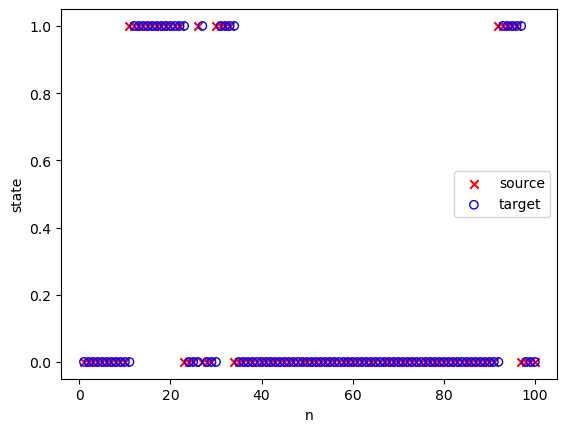

In [3]:
import matplotlib.pyplot as plt
plt.scatter(range(1,101), data[:100,0], marker='x', color='red', label='source')
plt.scatter(range(1,101), data[:100,1], marker='o', color='blue', facecolors='none', label='target')
plt.xlabel('n')
plt.ylabel('state')
plt.legend()
plt.show()

3. Open the AutoAnalyser and select Transfer Entropy. Select a Discrete estimator, select any discrete data file (e.g. `2coupledBinaryColsUseK2.txt`), leave the source and target at columns 0 and 1 respectively, uncheck `Compute result?`, and click `Generate Code`.
4. Copy and paste the generated Python code in the code cell below:

In [4]:
# Place the AutoAnalyser generated code template here, ready for editing.
# Put the import lines and JVM startup code here:

from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/home/joseph/JIDT/infodynamics-dist-1.6.1/demos/python")
import readIntsFile

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "/home/joseph/JIDT/infodynamics-dist-1.6.1/infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)


In [5]:
# Place the remainder of the auto-generated code here:

# 0. Load/prepare the data:
data = generateHeartbeatMessages(0.05, 0.2, 100000);
source = JArray(JInt, 1)(data[:,0].tolist())
destination = JArray(JInt, 1)(data[:,1].tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.discrete").TransferEntropyCalculatorDiscrete
calc = calcClass(2, 1, 1, 1, 1, 1)
# 2. No other properties to set for discrete calculators.
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.addObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()

print("TE_Discrete(col_0 -> col_1) = %.4f bits" %\
    (result))

# Challenge: Add statistical significance check:
# 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
measDist = calc.computeSignificance(100)
print("TE_Discrete(col_0 -> col_1) = %.4f bits (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
    (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, 100))

TE_Discrete(col_0 -> col_1) = 0.3715 bits
TE_Discrete(col_0 -> col_1) = 0.3715 bits (null: 0.0000 +/- 0.0000 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)


5. Replace the code at step 0 where the data file is loaded with the line we ran above to generate the heartbeat data sample: `data = generateHeartbeatMessages(0.05, 0.2, 100000);` (or you can load a saved sample data file as an alternative)
6. Run your Matlab script to check that it computes an average TE ok -- the result should be close to the theoretical value of 0.3735 bits for this large data sample.
    * Is this value statistically significant? (_Challenge_: can you check this?)
7. In the next code cell, add the following code to compute local TE at each time step: `locals = calc.computeLocalFromPreviousObservations(source, destination);`

In [6]:
# Compute the local TE at each time step here:

locals = calc.computeLocalFromPreviousObservations(source, destination);

8. In the next code cell, we will plot our results. First, replot the source and target time series (since we resampled `data`) -- copy the plotting code from step 2 above in below, and
9. Plot the local TE alongside the target variable in the next figure:
```python
plt.scatter(range(1,101), locals[:100], marker='x', color='red', label='TE (bits)')
plt.xlabel('n')
plt.ylabel('TE (bits)')
plt.legend(loc='upper left')
ax2 = plt.twinx()
ax2.scatter(range(1,101), data[:100,1], marker='o', color='blue', facecolors='none', label='target')
ax2.set_ylabel('state')
ax2.legend(loc='upper right')
plt.show()
```

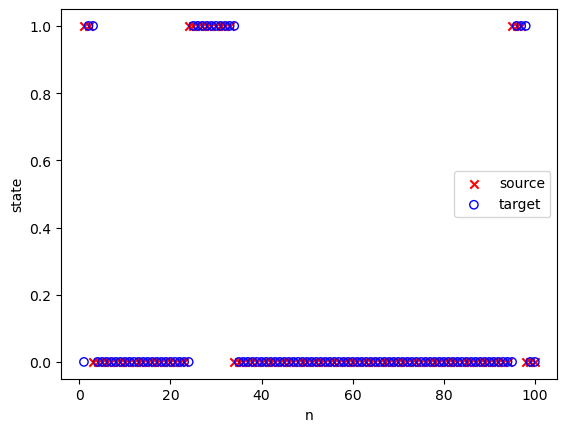

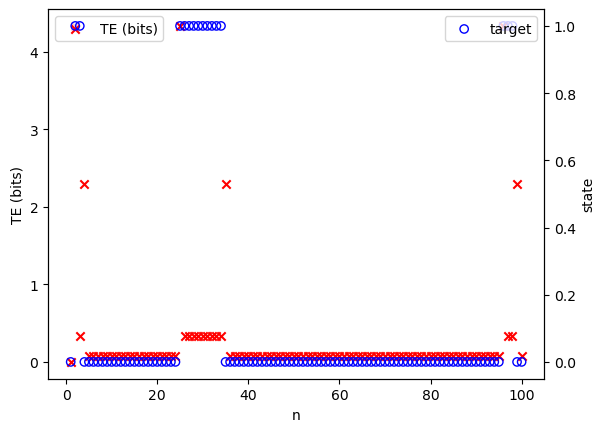

In [7]:
# Add the code to plot the results here:

# First replotting the source and target time series:
plt.scatter(range(1,101), data[:100,0], marker='x', color='red', label='source')
plt.scatter(range(1,101), data[:100,1], marker='o', color='blue', facecolors='none', label='target')
plt.xlabel('n')
plt.ylabel('state')
plt.legend()
plt.show()

# Then plotting the local TE alongside the target variable:
plt.scatter(range(1,101), locals[:100], marker='x', color='red', label='TE (bits)')
plt.xlabel('n')
plt.ylabel('TE (bits)')
plt.legend(loc='upper left')
ax2 = plt.twinx()
ax2.scatter(range(1,101), data[:100,1], marker='o', color='blue', facecolors='none', label='target')
ax2.set_ylabel('state')
ax2.legend(loc='upper right')
plt.show()

10. Examine the results (you may need to zoom in on the second figure above):
    * Where did the source add the _most_ information in the context of the target past? Why?
    * Where did the source add the _least_ information in the context of the target past? Why?
    * We don't see any negative values of local TE here - can you explain why?
11. _Challenge task_: Compute the local lagged mutual information (across one time step from the source to the target) by adding code below (e.g. by adapting the above code). Compare the results, and discuss why they are different. (Note that the local MI values generated by JIDT here will need a 0 padded to the front in order to align them with the local TE values.)

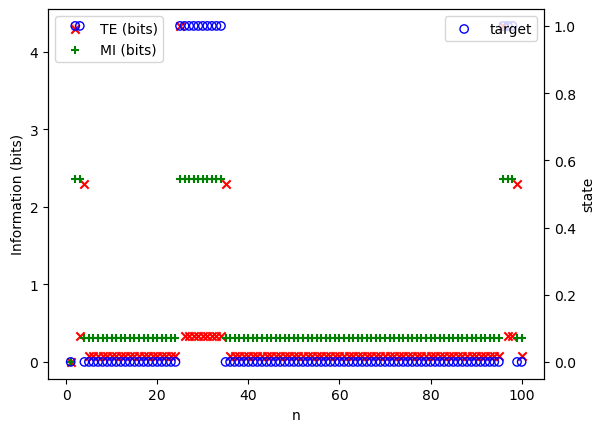

In [8]:
# 1. Creat MI Calc with time-lag 1 (Important to set this!)
miCalcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
miCalc = miCalcClass(2, 2, 1)
# 2. No other properties to set for discrete calculators.
# 3. Initialise the calculator for (re-)use:
miCalc.initialise()
# 4. Supply the sample data:
miCalc.addObservations(source, destination)
# 5. Compute the estimate:
result = miCalc.computeAverageLocalOfObservations()
# And compute the local values:
localsMI = miCalc.computeLocalFromPreviousObservations(source, destination);

# And our localsMI don't have a result for timestep 0 (where there is no history) yet TE does,
#  so align these properly:
localsMI = numpy.append([0], localsMI);

# Now plot them all together:
plt.scatter(range(1,101), locals[:100], marker='x', color='red', label='TE (bits)')
plt.scatter(range(1,101), localsMI[:100], marker='+', color='green', label='MI (bits)')
plt.xlabel('n')
plt.ylabel('Information (bits)')
plt.legend(loc='upper left')
ax2 = plt.twinx()
ax2.scatter(range(1,101), data[:100,1], marker='o', color='blue', facecolors='none', label='target')
ax2.set_ylabel('state')
ax2.legend(loc='upper right')
plt.show()

12. _Optional (and difficult!) Challenge task_: Calculate analytically the local transfer entropy for each configuration, as well as the average transfer entropy, that we expect to get here as a function of the transition probabilities $\lambda_0$ and $\lambda_1$. You can start with the transition probabilities $p(x_{n+1} | y_n, x_n)$ and $p(x_{n+1} | x_n)$ - and you will also need to work out the probabilities of each value $x_n = 0, 1$ of the target (the derivation for these is shown in the comments of `generateHeartbeatMessages()` if you get stuck), then plug everything through the TE equation. A full solution is available on the tutorial page.
13. _Optional Challenge task_: Can you compute and display how the average TE (not the local values) changes as a function of the transition probabilities $\lambda_0$ and $\lambda_1$?

There is a discussion of the results of this activity in a short video on the tutorial site.